In [27]:
import pandas as pd
import numpy as np

pull_request = pd.read_parquet("/Users/peter/Library/CloudStorage/OneDrive-Personal/Documents/MDS_UBC/DATA_542/Project/dataset/pull_request.parquet")
pr_reviews = pd.read_parquet("/Users/peter/Library/CloudStorage/OneDrive-Personal/Documents/MDS_UBC/DATA_542/Project/dataset/pr_reviews.parquet")
pr_comments = pd.read_parquet("/Users/peter/Library/CloudStorage/OneDrive-Personal/Documents/MDS_UBC/DATA_542/Project/dataset/pr_comments.parquet")
pr_commits = pd.read_parquet("/Users/peter/Library/CloudStorage/OneDrive-Personal/Documents/MDS_UBC/DATA_542/Project/dataset/pr_commits.parquet")
pr_timeline = pd.read_parquet("/Users/peter/Library/CloudStorage/OneDrive-Personal/Documents/MDS_UBC/DATA_542/Project/dataset/pr_timeline.parquet")

In [8]:
#Getting pr_id from pr_reviews where a human is involved
pr_id_human_reviews = pr_reviews.loc[
    pr_reviews['user_type'] != "Bot",  
    'pr_id'                            
].drop_duplicates()
len(pr_id_human_reviews)


6004

In [13]:
#Getting pr_id from pr_comments where a human is involved
pr_id_human_comments = pr_comments.loc[
    pr_comments['user_type'] != "Bot",
    'pr_id'
].drop_duplicates()
len(pr_id_human_comments)

5350

In [21]:
#Getting pr_id from pr_commits where for this pr_id, one of the commits was authored by human, or co-authored with a human
#In addition, we want to exclude non code commits since, since there are commits that are for administrative tasks like
# merge, close, 
#So if the entire pr was authored by bot, but only merged by human, it would still be counted as done by bots only

#We can get a list of all the events type in pr_timeline

pr_timeline.loc[:,"event"].unique()




array(['head_ref_force_pushed', 'committed', 'merged', 'closed',
       'head_ref_deleted', 'commented', 'reviewed', 'renamed',
       'unsubscribed', 'labeled', 'deployed', 'review_requested',
       'mentioned', 'subscribed', 'assigned', 'referenced',
       'base_ref_changed', 'review_request_removed', 'unlabeled',
       'auto_squash_enabled', 'automatic_base_change_succeeded',
       'connected', 'convert_to_draft', 'ready_for_review',
       'added_to_merge_queue', 'removed_from_merge_queue',
       'base_ref_force_pushed', 'auto_merge_enabled',
       'auto_merge_disabled', 'milestoned', 'marked_as_duplicate',
       'locked', 'reopened', 'head_ref_restored', 'review_dismissed',
       'unassigned', 'comment_deleted', 'demilestoned',
       'base_ref_deleted', 'copilot_work_started',
       'copilot_work_finished', 'copilot_work_finished_failure',
       'auto_rebase_enabled', 'disconnected', 'unlocked', 'user_blocked'],
      dtype=object)

In [22]:
#We say say the following are non code editing/code contribution related commits or only final commits related to a PR 
# like merge and close:
non_code_events = [
    "closed",
    "merged",
    "reopened",
    "auto_merge_disabled",
    "auto_merge_enabled",
    "labeled",
    "unlabeled",
    "milestoned",
    "demilestoned",
    "assigned",
    "unassigned",
    "subscribed",
    "unsubscribed",
    "mentioned",
    "referenced",
    "user_blocked",
    "locked",
    "unlocked",
    "marked_as_duplicate",
]


In [ ]:

#Since pr_commits has no user_type columns, we can get the list of bots from from pr_review and pr_comments
bot_list_1 = pr_reviews.loc[
    pr_reviews["user_type"] == "Bot", "user"
    ]

bot_list_2 = pr_comments.loc[
    pr_comments["user_type"] == "Bot", "user"
    ]

bot_list = pd.concat([bot_list_1, bot_list_2]).dropna().drop_duplicates()

#Getting a list of commits_id that are non_code related
non_code_related_commits = pr_timeline.loc[
    pr_timeline["event"].isin(non_code_events),
    "commit_id",
].dropna().drop_duplicates()


#This gives you a full list of pr_id and the related human commits
pr_id_human_commits = pr_commits.loc[
    ~pr_commits["author"].isin(bot_list),
    ["pr_id", "sha"],
]
#Excluding administrative commits. This table contains pr_id that follow these 2 rules
#1.	Have at least one commit authored by a non-bot user, and
#2.	That commit’s sha is not tied to a non-code / admin event in pr_timeline.
pr_id_human_commits = pr_id_human_commits.loc[
    ~pr_id_human_commits["sha"].isin(non_code_related_commits),
    "pr_id",
].drop_duplicates()

len(pr_id_human_commits)

26817

In [30]:
# List of pr_id where human interactions are involved 
# 2 levels : level 1 is if human only involved in the review process (pr_id in the reviews or comments)
# level 2 is if a human directly contributed into the code 

# All PRs with any human interaction
pr_id_human = pd.concat(
    [pr_id_human_commits, pr_id_human_comments, pr_id_human_reviews],
    ignore_index=True,
).drop_duplicates()

# Build table
pr_human_level = pd.DataFrame({"pr_id": pr_id_human})

pr_human_level["level"] = np.where(
    pr_human_level["pr_id"].isin(pr_id_human_commits),
    2, # has human commit
    1, # only comments/reviews
)

pr_human_level.shape[0]



30391

In [33]:
# List of pr_id where no human interactions were involved
pr_id_bot = pull_request.loc[
    ~pull_request['id'].isin(pr_id_human),
    "id"
]

pr_bot = pd.DataFrame({"pr_id": pr_id_bot})

pr_bot["level"] = np.zeros(pr_bot.shape[0])




In [ ]:
#This table contains every pull_request ID label them as 0,1,2 to determine human interaction
# 0 = only bots, 1 = human reviews+comments , 2 = human code 
full_pr_level = pd.concat([pr_human_level, pr_bot], ignore_index=True)
len(full_pr_level)


33596

In [37]:
#sanity check 
full_pr_level.shape[0] == pull_request.shape[0]

True

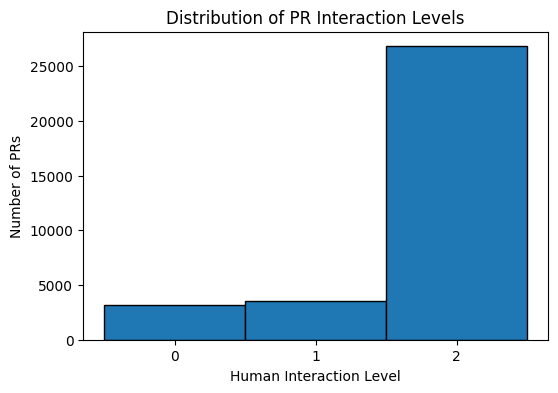

In [38]:
#histogram

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(full_pr_level["level"], bins=[-0.5, 0.5, 1.5, 2.5], edgecolor="black")
plt.xticks([0, 1, 2])
plt.xlabel("Human Interaction Level")
plt.ylabel("Number of PRs")
plt.title("Distribution of PR Interaction Levels")
plt.show()

In [39]:
full_pr_level.to_csv("pr_with_human_interaction_levels.csv", index=False)